## Mall Customer Segmentation

**Context**

This data set is created only for the learning purpose of the customer segmentation concepts, also known as market basket analysis.

**Problem Statement**

You are owing a supermarket mall and through membership cards, you have some basic data about your customers like Customer ID, age, gender, annual income and spending score. Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.



# Libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import pandas as pd
import numpy  as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt
import seaborn           as sns


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
#
from utils.check_skew    import *
from utils.snake_plot    import *

# Import data


In [3]:
df = pd.read_csv( 'Data/Mall_Customers.csv' )

df.head( 3 )

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


## Pre-process data

In [4]:
df.drop(['CustomerID'], axis = 1, inplace = True)

In [5]:
# Convert class variable from categorical to numerical
#
from sklearn.preprocessing import LabelEncoder

# Setup Encoder
le = LabelEncoder()

# Apply Encoder
df['Gender'] = le.fit_transform( df['Gender'] )


# df['Gender_M'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
# df['Gender_F'] = df['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
# #
# df.drop(['Gender'], axis = 1, inplace = True)

# Clustering

## Skewness check

Plotting distribution charts to check for skewness

[INFO] Feature: Gender
> Skew: 0.24174688920761428
> SkewtestResult(statistic=1.4256297090878416, pvalue=0.15397525593113012)


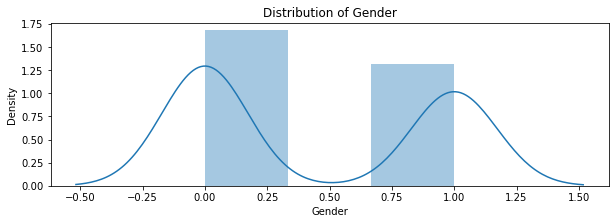

[INFO] Feature: Age
> Skew: 0.48191947090957177
> SkewtestResult(statistic=2.746320082486241, pvalue=0.006026793226593931)


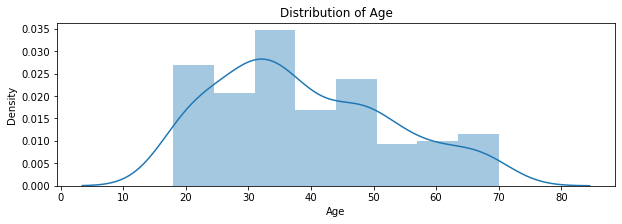

[INFO] Feature: Annual Income (k$)
> Skew: 0.319423684276314
> SkewtestResult(statistic=1.8666998720159191, pvalue=0.061943511635953546)


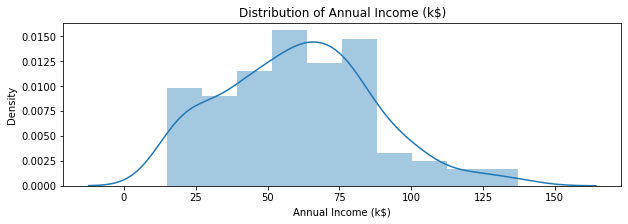

[INFO] Feature: Spending Score (1-100)
> Skew: -0.04686530945553505
> SkewtestResult(statistic=-0.27978204350670033, pvalue=0.7796447289541806)


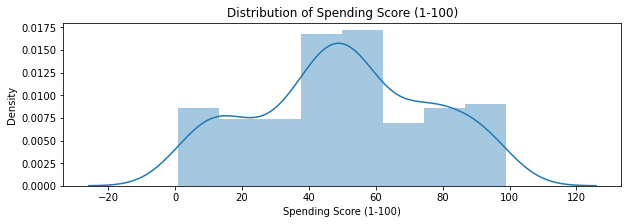

In [6]:
# Plot all Distrubution graphs

for feature in df.columns:
    check_skew(df, feature);

**Findings:** The data is not skewed - No need for transformation

## Data pre-processing for clustering

In [7]:
from sklearn.preprocessing import StandardScaler


# Setup scaler
#
scaler = StandardScaler()


# Apply scaler
#
df_scaled = pd.DataFrame(data    = scaler.fit_transform( df.values ),
                         index   = df.index,
                         columns = df.columns)

## K-Means clustering process

### Finding the optimal number of clusters


In [8]:
from sklearn.cluster        import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics        import silhouette_score

distortions = [] 
inertias    = [] 
Clusters    = [ [] ]
Centroids   = [ [] ]
K = range(1, 21)
  
for k in K: 
    # Setup K-Means model     
    model = KMeans(n_clusters = k, random_state = 42)
    
    # Fit model
    model.fit( df_scaled )     

    # Store clusters
    Clusters  += [ model.labels_.tolist() ]
    
    # Get centroids
    Centroids += [ model.cluster_centers_ ]

    # Calculate distortions
    distortions.append( sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'),axis=1)) / df_scaled.shape[0] ) 

    # Calculate inertias
    inertias.append( model.inertia_ ) 
  
    # Calculate Silhouette score
    if (k > 1):
        Sil = silhouette_score(X     = df_scaled, 
                              labels = model.labels_)

        print('K = %2i Silhouette Score %.3f' % (k, Sil))

K =  2 Silhouette Score 0.252
K =  3 Silhouette Score 0.260
K =  4 Silhouette Score 0.302
K =  5 Silhouette Score 0.317
K =  6 Silhouette Score 0.334
K =  7 Silhouette Score 0.357
K =  8 Silhouette Score 0.387
K =  9 Silhouette Score 0.402
K = 10 Silhouette Score 0.420
K = 11 Silhouette Score 0.427
K = 12 Silhouette Score 0.425
K = 13 Silhouette Score 0.428
K = 14 Silhouette Score 0.430
K = 15 Silhouette Score 0.422
K = 16 Silhouette Score 0.429
K = 17 Silhouette Score 0.434
K = 18 Silhouette Score 0.431
K = 19 Silhouette Score 0.441
K = 20 Silhouette Score 0.410


### Elbow Method using Distortion and Inertia

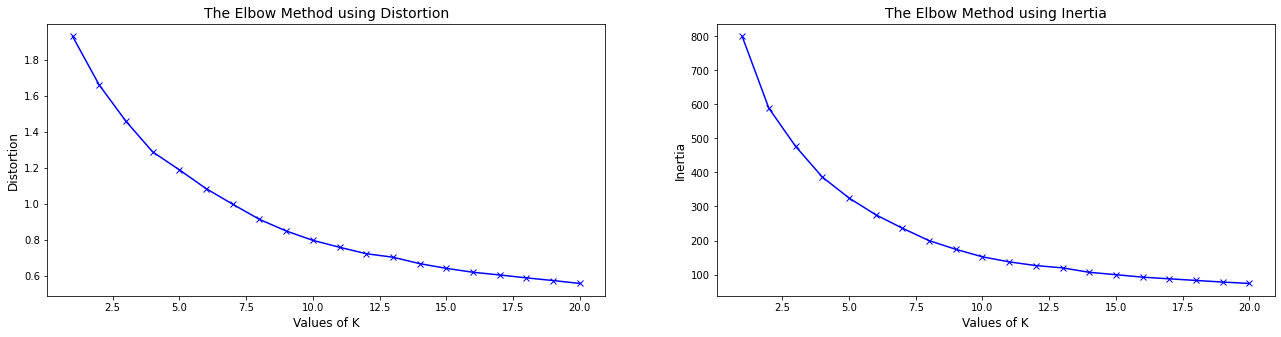

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (22, 5) )
#
ax[0].plot(K, distortions, 'bx-') 
ax[0].set_xlabel('Values of K', size = 12) 
ax[0].set_ylabel('Distortion', size = 12) 
ax[0].set_title('The Elbow Method using Distortion', size = 14) 
#
ax[1].plot(K, inertias, 'bx-') 
ax[1].set_xlabel('Values of K', size = 12) 
ax[1].set_ylabel('Inertia', size = 12) 
ax[1].set_title('The Elbow Method using Inertia', size = 14)

plt.show();

## Cluster visualization

In [10]:
import umap

UMAP_arg    = { 'n_neighbors': 30, 
                'min_dist':    0.01 }

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Apply UMAP
#
umapModel = umap.UMAP(n_neighbors  = UMAP_arg['n_neighbors'],
                      min_dist     = UMAP_arg['min_dist'],
                      n_components = 2,
                      random_state = 42)

embeddings = umapModel.fit_transform( df_scaled.to_numpy() )

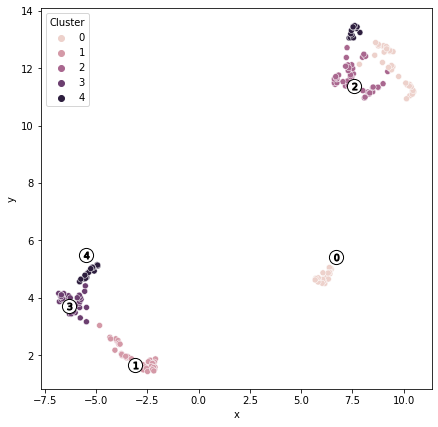

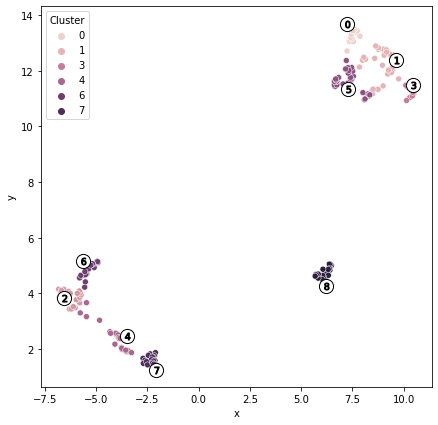

In [13]:
# Create DataFrame
# 
clustering_df = pd.DataFrame( embeddings, columns = ['x', 'y'] )

for k in [5, 9]:
    # Get Cluster    
    clustering_df['Cluster'] = Clusters[k]


    # Clustering visualization in 2D
    #
    plt.figure( figsize = (7, 7) )
    sns.scatterplot(data = clustering_df, x = 'x', y = 'y', hue = 'Cluster')

    # Plot centroids
    #
    centers = umapModel.transform( Centroids[ k ] )
    plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate( centers ):
            plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s = 50, edgecolor='k')

### Snake plots


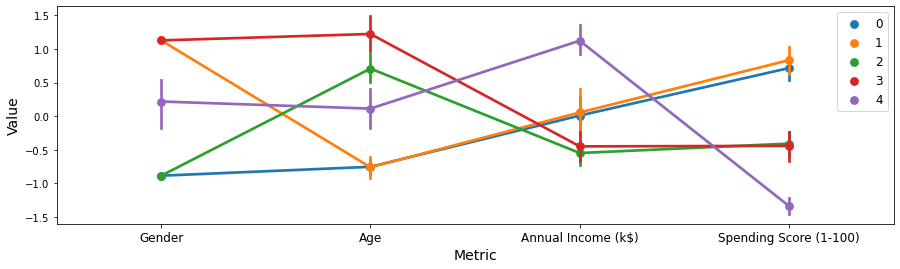

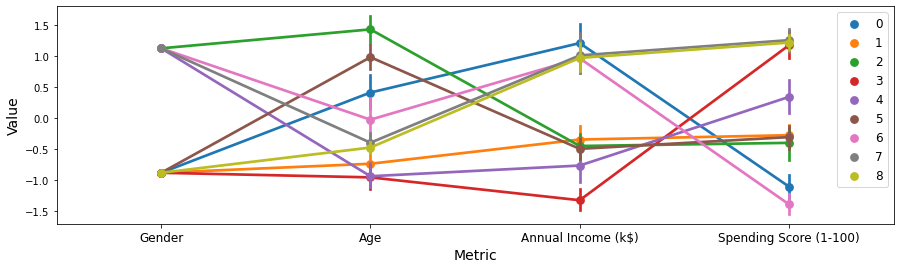

In [14]:
for k in [5, 9]:
    snake_plot(df_scaled.copy(), Clusters[k], df_scaled.reset_index()['index'])

### Clustering evaluation

Silhouette visualizer

In [20]:
# Selected number of clusters
# 
n_clusters = 5

# Setup model
model = KMeans(n_clusters = n_clusters).fit( df_scaled ) 

# Fit model
model.fit( df_scaled )     

# Get Clustering-Results
df[ 'Cluster' ] = model.labels_

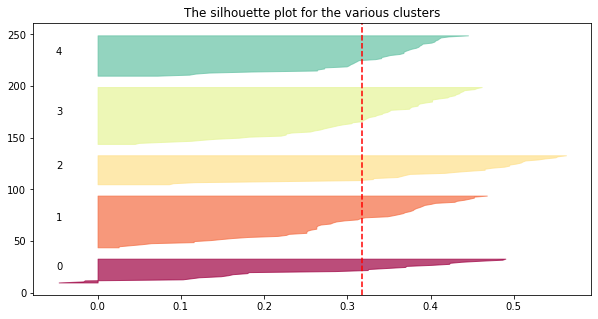

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

plt.figure( figsize = (10, 5))


Sil = silhouette_score(X      = df_scaled, 
                       labels = df[ 'Cluster' ])


sample_silhouette_values = silhouette_samples(X = df_scaled, labels = df['Cluster'])

y_lower = 10
for i in range( n_clusters ):
    ith_cluster_silhouette_values = sample_silhouette_values[ df['Cluster'] == i ]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
plt.axvline(x = Sil, color="red", linestyle="--")

# Set figure title
#
plt.title('The silhouette plot for the various clusters');

### Interpretation of the clusters formed using k-means

<Figure size 1440x432 with 0 Axes>

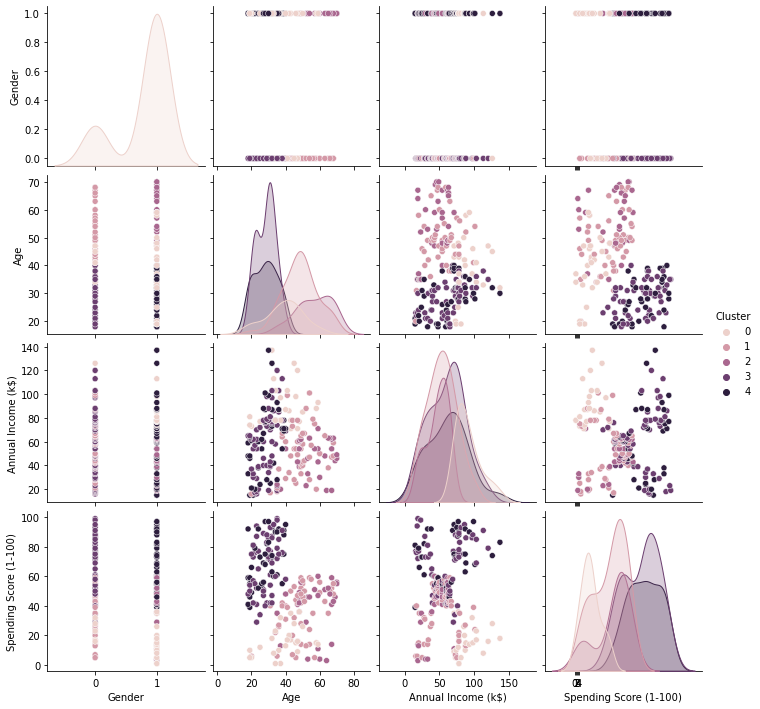

In [22]:

plt.figure( figsize = (20, 6) )
#
#
sns.pairplot(data = df, hue = 'Cluster')
#
plt.xticks( np.arange(n_clusters), size = 12 );
plt.yticks( size = 12 );